In [ ]:
# Download Historical Stock Data

import pandas as pd
import yfinance as yf
import numpy as np

# Define the stock tickers and download data
tickers = ['AAPL', 'GOOGL', 'MSFT']
data = yf.download(tickers, start='2010-01-01', end='2024-01-06')

# Use the closing prices
data = data['Close']

# Check for NaN values in the dataset
nan_counts = data.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

# Display rows with NaN values
nan_rows = data[data.isna().any(axis=1)]
print("Rows with NaN values:\n", nan_rows)

# Fill missing values by backfilling
data = data.bfill()
print("Data after filling missing values:\n", data.head(25))


[*********************100%%**********************]  3 of 3 completed

Number of NaN values in each column:
 Ticker
AAPL     0
GOOGL    0
MSFT     0
dtype: int64
Rows with NaN values:
 Empty DataFrame
Columns: [AAPL, GOOGL, MSFT]
Index: []
Data after filling missing values:
 Ticker          AAPL      GOOGL       MSFT
Date                                      
2010-01-04  7.643214  15.684434  30.950001
2010-01-05  7.656429  15.615365  30.959999
2010-01-06  7.534643  15.221722  30.770000
2010-01-07  7.520714  14.867367  30.450001
2010-01-08  7.570714  15.065566  30.660000
2010-01-11  7.503929  15.042793  30.270000
2010-01-12  7.418571  14.776777  30.070000
2010-01-13  7.523214  14.691942  30.350000
2010-01-14  7.479643  14.761011  30.959999
2010-01-15  7.354643  14.514515  30.860001
2010-01-19  7.680000  14.705205  31.100000
2010-01-20  7.561786  14.524775  30.590000
2010-01-21  7.431071  14.589089  30.010000
2010-01-22  7.062500  13.764014  28.959999
2010-01-25  7.252500  13.513514  29.320000
2010-01-26  7.355000  13.574074  29.500000
2010-01-27  7.424286 

In [ ]:
# Calculate the 50-day moving average for each stock
data['AAPL_MA50'] = data['AAPL'].rolling(window=50).mean()
data['GOOGL_MA50'] = data['GOOGL'].rolling(window=50).mean()
data['MSFT_MA50'] = data['MSFT'].rolling(window=50).mean()

# Fill NaN values created by rolling operation
data = data.bfill()

print("Data with 50-day moving average:\n", data.head(25))



Data with 50-day moving average:
 Ticker          AAPL      GOOGL       MSFT  AAPL_MA50  GOOGL_MA50  MSFT_MA50
Date                                                                        
2010-01-04  7.643214  15.684434  30.950001   7.391336   13.955175    29.1646
2010-01-05  7.656429  15.615365  30.959999   7.391336   13.955175    29.1646
2010-01-06  7.534643  15.221722  30.770000   7.391336   13.955175    29.1646
2010-01-07  7.520714  14.867367  30.450001   7.391336   13.955175    29.1646
2010-01-08  7.570714  15.065566  30.660000   7.391336   13.955175    29.1646
2010-01-11  7.503929  15.042793  30.270000   7.391336   13.955175    29.1646
2010-01-12  7.418571  14.776777  30.070000   7.391336   13.955175    29.1646
2010-01-13  7.523214  14.691942  30.350000   7.391336   13.955175    29.1646
2010-01-14  7.479643  14.761011  30.959999   7.391336   13.955175    29.1646
2010-01-15  7.354643  14.514515  30.860001   7.391336   13.955175    29.1646
2010-01-19  7.680000  14.705205  31.100000

In [ ]:
# Scale the Data

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler and fit to the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print("Scaled data sample:\n", data_scaled[:5])


Scaled data sample:
 [[0.00410081 0.03434761 0.02207456 0.         0.01562903 0.0134612 ]
 [0.00416991 0.03385045 0.02210236 0.         0.01562903 0.0134612 ]
 [0.00353313 0.03101697 0.02157413 0.         0.01562903 0.0134612 ]
 [0.00346029 0.02846629 0.02068448 0.         0.01562903 0.0134612 ]
 [0.00372173 0.02989295 0.02126831 0.         0.01562903 0.0134612 ]]


In [ ]:
# Split the data into training and testing sets
def split_data(data, split_ratio):
    train_size = int(len(data) * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

split_ratios = [0.8]
datasets = [split_data(data_scaled, ratio) for ratio in split_ratios]

for i, (train_data, test_data) in enumerate(datasets):
    print(f"Training data size for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {train_data.shape}")
    print(f"Testing data size for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {test_data.shape}")


Training data size for split 80.0-19.999999999999996: (2820, 6)
Testing data size for split 80.0-19.999999999999996: (706, 6)


In [ ]:
# Create Time-Series Data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Create feature set
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Create label set
    return np.array(X), np.array(Y)

time_step = 100
datasets_ts = [(create_dataset(train, time_step), create_dataset(test, time_step)) for train, test in datasets]

for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    print(f"X_train shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {X_train.shape}")
    print(f"X_test shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {X_test.shape}")


X_train shape for split 80.0-19.999999999999996: (2719, 100, 1)
X_test shape for split 80.0-19.999999999999996: (605, 100, 1)


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [8]:
# Build and Train LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Build and Train LSTM Model
def build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=10, batch_size=1):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

hyperparams = [
    {'epochs': 2, 'batch_size': 1},
    {'epochs': 2, 'batch_size': 32}
#   {'epochs': 5, 'batch_size': 1},
#   {'epochs': 5, 'batch_size': 32}
]

lstm_results = []
for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    for params in hyperparams:
        print(f"Training LSTM model with split {split_ratios[i]*100}-{(1-split_ratios[i])*100} and params {params}...")
        model, history = build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'])
        lstm_results.append((model, history, f"Split {split_ratios[i]*100}-{(1-split_ratios[i])*100}, Params {params}"))


Training LSTM model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 1}...
Epoch 1/2
 476/2719 [====>.........................] - ETA: 2:18 - loss: 0.0017

In [ ]:
# Build and Train GRU Model

from tensorflow.keras.layers import GRU

def build_and_train_gru(X_train, y_train, X_test, y_test, epochs=10, batch_size=1):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

gru_results = []
for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    for params in hyperparams:
        print(f"Training GRU model with split {split_ratios[i]*100}-{(1-split_ratios[i])*100} and params {params}...")
        model, history = build_and_train_gru(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'])
        gru_results.append((model, history, f"Split {split_ratios[i]*100}-{(1-split_ratios[i])*100}, Params {params}"))


Training GRU model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 1}...
Epoch 1/2
1457/2719 [===============>..............] - ETA: 1:13:35 - loss: 5.0310e-04

In [ ]:
# Evaluate Models

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = np.corrcoef(y_test, test_predict)[0, 1]**2

    return rmse, mae, r2, y_test, test_predict

# Evaluate LSTM models
lstm_eval_results = []
for model, history, desc in lstm_results:
    for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
        rmse, mae, r2, y_test_lstm, test_predict_lstm = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
        lstm_eval_results.append((rmse, mae, r2, desc))

# Evaluate GRU models
gru_eval_results = []
for model, history, desc in gru_results:
    for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
        rmse, mae, r2, y_test_gru, test_predict_gru = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
        gru_eval_results.append((rmse, mae, r2, desc))

# Print evaluation results
print("\nLSTM Evaluation Results:")
for rmse, mae, r2, desc in lstm_eval_results:
    print(f"{desc} - RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")

print("\nGRU Evaluation Results:")
for rmse, mae, r2, desc in gru_eval_results:
    print(f"{desc} - RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")


19/19 [==============================] - 9s 465ms/step

LSTM Evaluation Results:
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 1} - RMSE: 7.591974796690578, MAE: 6.511576224435586, R-squared: 0.9403630208697717
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 32} - RMSE: 11.327968786284446, MAE: 9.842717282270701, R-squared: 0.8764543135507981

GRU Evaluation Results:
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 1} - RMSE: 3.1190309202024795, MAE: 2.475938262944015, R-squared: 0.97116745525011
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 32} - RMSE: 4.796118091733977, MAE: 3.9891436227090624, R-squared: 0.946595391660148


In [ ]:
# You will need to install chrome driver for this section to work correctly
# Download the appropriate chrome driver to match you browser version from https://developer.chrome.com/docs/chromedriver/downloadshttps://developer.chrome.com/docs/chromedriver/downloads
# Replace the path in chromedriver_path = r'C:\Users\RobertRodrigues\Documents\downloads\chromedriver-win32\chromedriver-win32\chromedriver.exe' with where you place your .exe

# Collect News Data
import os
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt


# Set up Chrome options
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-gpu')
options.add_argument('--remote-debugging-port=9222')
options.add_argument('--window-size=1920x1080')

# Specify the correct path to chromedriver
chromedriver_path = r'C:\Users\RobertRodrigues\Documents\downloads\chromedriver-win32\chromedriver-win32\chromedriver.exe'

def scrape_news(stock):
    driver = webdriver.Chrome(service=Service(chromedriver_path), options=options)
    url = f'https://news.google.com/search?q={stock}%20stock&hl=en-US&gl=US&ceid=US%3Aen'
    driver.get(url)
    
    # Allow time for the page to load and find headlines
    try:
        print(f"Fetching news for {stock}...")
        article_elements = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'article.IFHyqb'))
        )
        
        headlines = []
        for article in article_elements:
            headline_element = article.find_element(By.CSS_SELECTOR, 'a.JtKRv')
            if headline_element:
                headlines.append(headline_element.text)
        
        print(f"Headlines found: {headlines}")
    except Exception as e:
        print(f"An error occurred: {e}")
        headlines = []
    finally:
        driver.quit()
    
    return headlines

# Scrape news for each stock
news_aapl = scrape_news('AAPL')
news_googl = scrape_news('GOOGL')
news_msft = scrape_news('MSFT')




Fetching news for AAPL...
Headlines found: ['Jim Cramer Says He’s Still a ‘Believer’ in Apple Inc (NASDAQ:AAPL)', 'Apple Stock: Upcoming Q3 Earnings Report May Be Irrelevant (NASDAQ:AAPL)', 'Apple Stock Has More Upside, Analyst Says. Why It’s Still Falling Today.', 'Needham Analyst Raises Price Target for AAPL', 'How Apple Is Capitalizing On Its Balance Sheet To Drive AI Growth (NASDAQ:AAPL)', 'Small Caps Jump, Techs Slump As Prices Cool; KBH, URBN, AAPL In Focus - Video - IBD', 'Mac Sales Set to Rise 20.8%: Should You Buy Apple (AAPL) Stock?', '3 Stocks to Hold for The Next Decade and Beyond', 'AAPL: Apple Stock Hits Unseen Milestone of $3.5 Trillion as Shares Soar to Record', "Palantir, Apple, Costco, SoundHound AI, Tesla: Why These 5 Stocks Are On Investors' Radars Today", 'Apple Stock Got Bit By Sellers Thursday: What Happened?', 'Apple (AAPL) Outpaces Stock Market Gains: What You Should Know', 'Is Apple Stock A Buy After Tech Giant Hits $3.5 Trillion Market Cap?', 'Could Apple bec

In [ ]:
# Sentiment Analysis

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function to calculate sentiment scores
def get_sentiment_scores(headlines):
    scores = [analyzer.polarity_scores(headline)['compound'] for headline in headlines]
    return scores

# Get sentiment scores for each stock
sentiment_aapl = get_sentiment_scores(news_aapl)
sentiment_googl = get_sentiment_scores(news_googl)
sentiment_msft = get_sentiment_scores(news_msft)

# Ensure the lengths of sentiment arrays are the same
min_length = min(len(sentiment_aapl), len(sentiment_googl), len(sentiment_msft))
sentiment_aapl = sentiment_aapl[:min_length]
sentiment_googl = sentiment_googl[:min_length]
sentiment_msft = sentiment_msft[:min_length]

# Calculate average sentiment
avg_sentiment_aapl = sum(sentiment_aapl) / len(sentiment_aapl)
avg_sentiment_googl = sum(sentiment_googl) / len(sentiment_googl)
avg_sentiment_msft = sum(sentiment_msft) / len(sentiment_msft)

print(f'Average Sentiment - AAPL: {avg_sentiment_aapl}, GOOGL: {avg_sentiment_googl}, MSFT: {avg_sentiment_msft}')

Average Sentiment - AAPL: 0.171953, GOOGL: 0.17810299999999998, MSFT: 0.20480099999999996


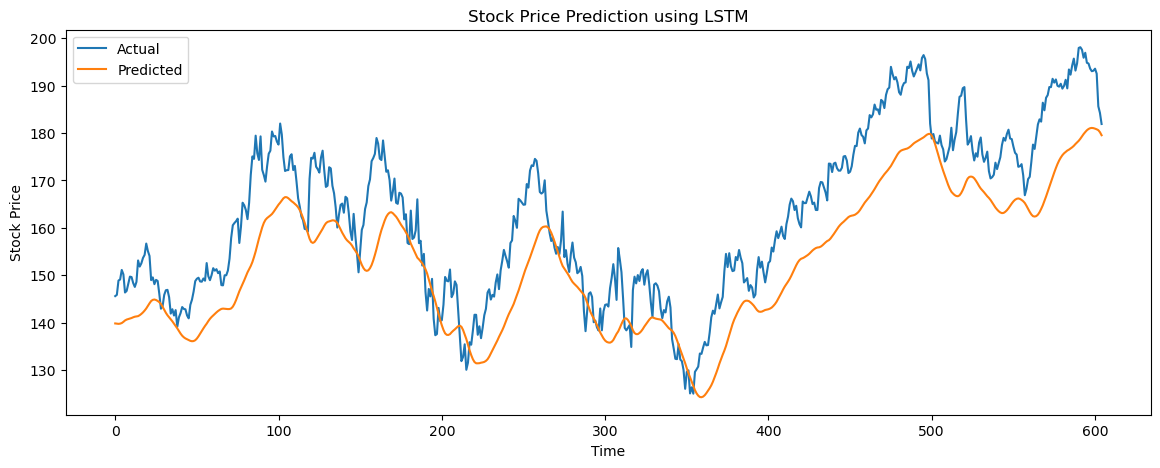

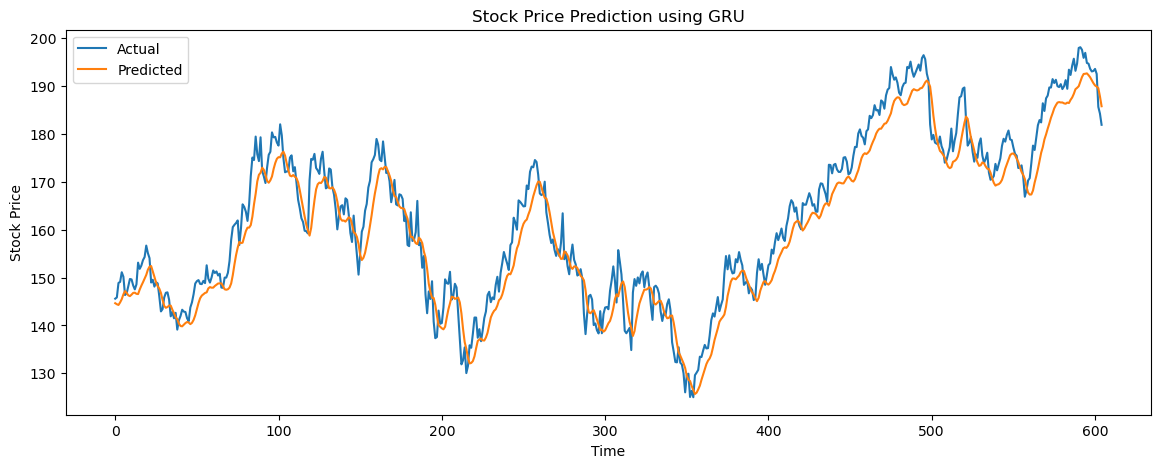

In [ ]:
# Visualizations

import matplotlib.pyplot as plt

# Plot LSTM predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(test_predict_lstm, label='Predicted')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot GRU predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_gru, label='Actual')
plt.plot(test_predict_gru, label='Predicted')
plt.title('Stock Price Prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


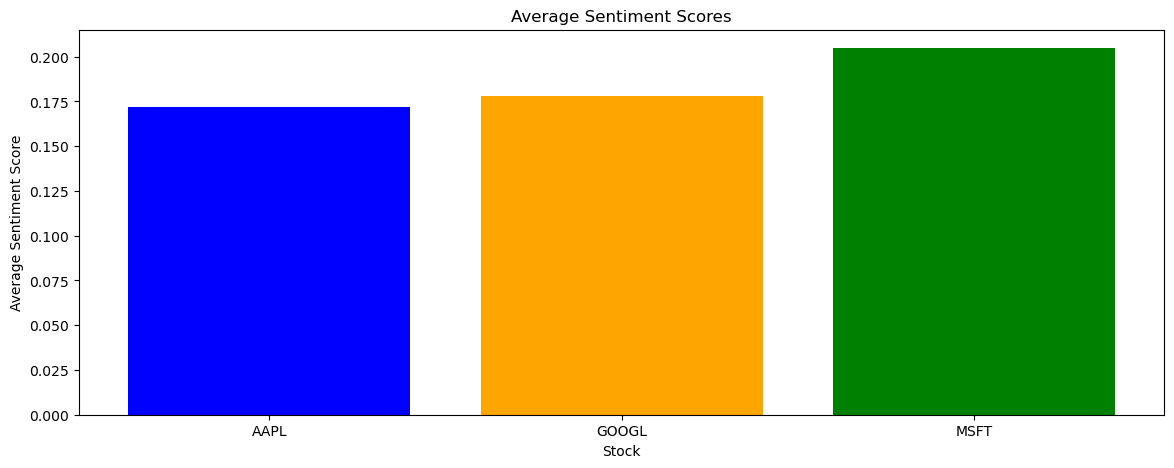

In [ ]:
# Plot sentiment scores for each stock
plt.figure(figsize=(14, 5))
plt.bar(['AAPL', 'GOOGL', 'MSFT'], [avg_sentiment_aapl, avg_sentiment_googl, avg_sentiment_msft], color=['blue', 'orange', 'green'])
plt.title('Average Sentiment Scores')
plt.xlabel('Stock')
plt.ylabel('Average Sentiment Score')
plt.show()



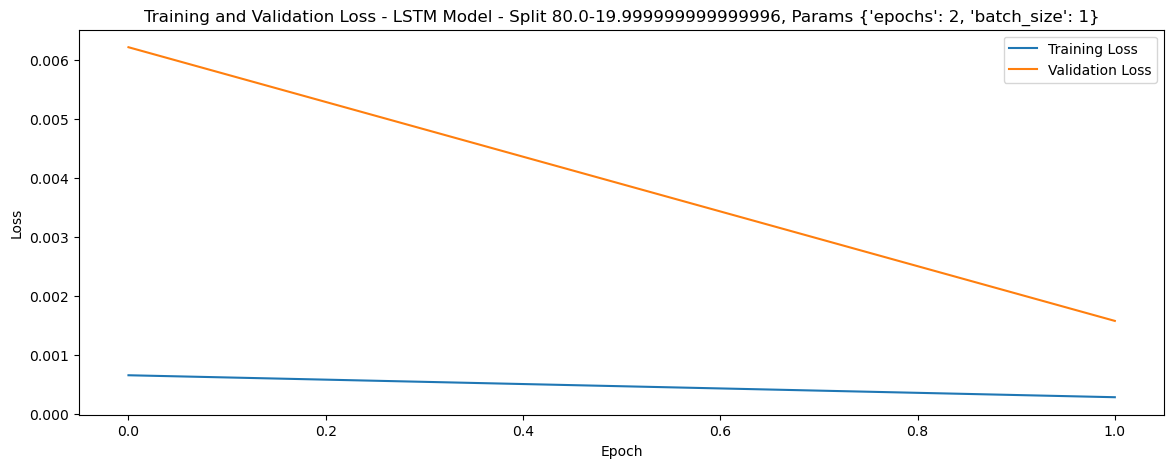

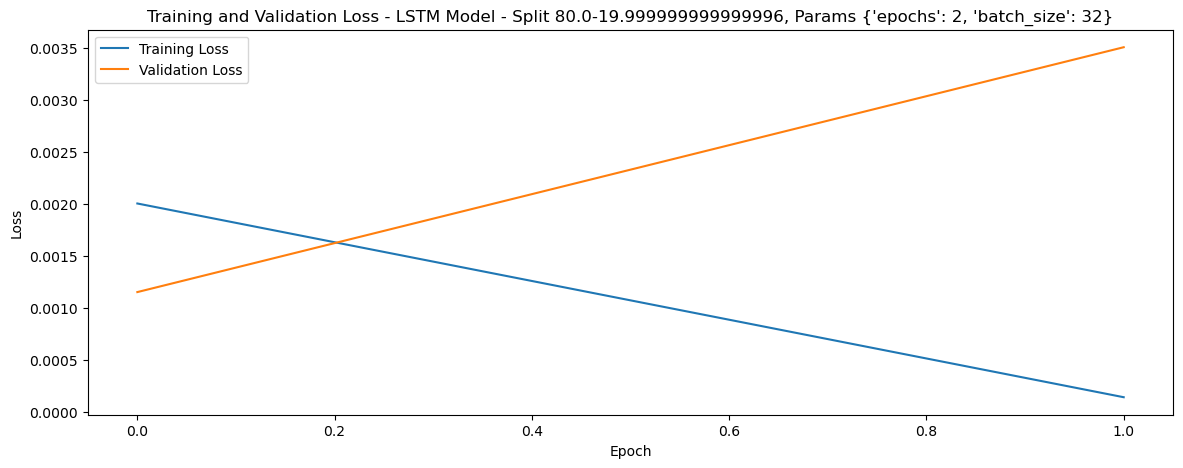

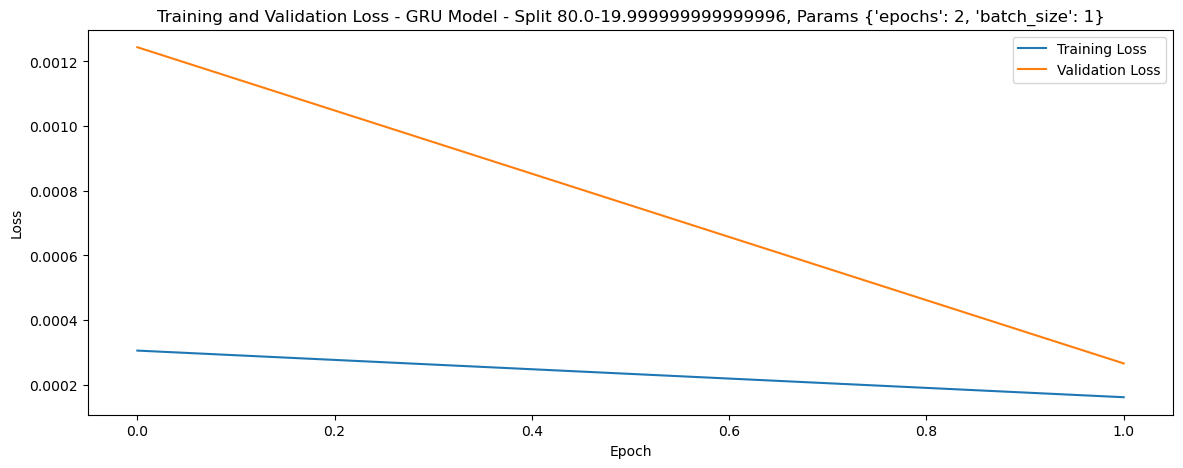

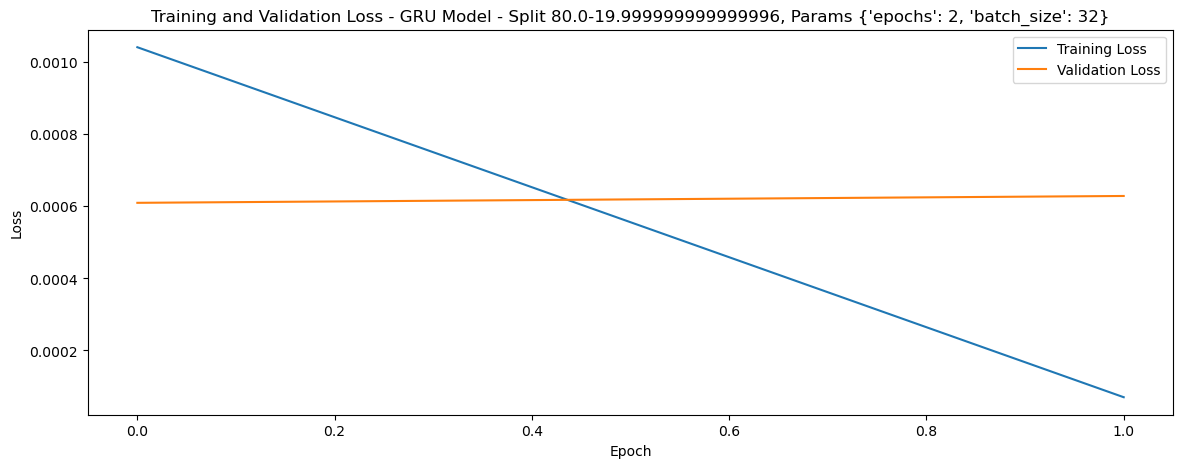

In [ ]:
# Plot training and validation loss for LSTM model
for model, history, desc in lstm_results:
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - LSTM Model - {desc}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training and validation loss for GRU model
for model, history, desc in gru_results:
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - GRU Model - {desc}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
# Integrate Sentiment Data with Stock Prices

# Sample stock price data
dates = pd.date_range(start='2024-01-01', periods=min_length, freq='D')
data = pd.DataFrame(index=dates)
data['AAPL'] = np.random.rand(min_length)  # Replace with actual stock price data
data['GOOGL'] = np.random.rand(min_length)  # Replace with actual stock price data
data['MSFT'] = np.random.rand(min_length)  # Replace with actual stock price data

# Convert sentiment scores to DataFrame
sentiment_df = pd.DataFrame({
    'AAPL_Sentiment': sentiment_aapl,
    'GOOGL_Sentiment': sentiment_googl,
    'MSFT_Sentiment': sentiment_msft
}, index=dates)  # Ensure indices match

# Combine sentiment scores with stock price data
data = data.join(sentiment_df, how='inner')

# Fill missing values created by aligning the sentiment data with the stock price data
data = data.bfill()

# Scale the updated data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Function to split data into training and testing sets
def split_data(dataset, ratio=0.8):
    train_size = int(len(dataset) * ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

# Prepare data for LSTM with sentiment
time_step = 10
split_ratios = [0.8]
datasets = [split_data(data_scaled, ratio) for ratio in split_ratios]
datasets_ts = [(create_dataset(train, time_step), create_dataset(test, time_step)) for train, test in datasets]

for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    print(f"X_train shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100} with sentiment: {X_train.shape}")
    print(f"X_test shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100} with sentiment: {X_test.shape}")

# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=2, batch_size=1):
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = r2_score(y_test, test_predict)
    return rmse, mae, r2

# Train and evaluate models
rmse_lstm, mae_lstm, r2_lstm = train_and_evaluate_model(build_lstm_model((time_step, data_scaled.shape[1])), 
                                                        X_train, y_train, X_test, y_test, epochs=2, batch_size=1)
rmse_gru, mae_gru, r2_gru = train_and_evaluate_model(build_gru_model((time_step, data_scaled.shape[1])), 
                                                     X_train, y_train, X_test, y_test, epochs=2, batch_size=1)



X_train shape for split 70.0-30.000000000000004 with sentiment: (59, 10, 6)
X_test shape for split 70.0-30.000000000000004 with sentiment: (19, 10, 6)
X_train shape for split 80.0-19.999999999999996 with sentiment: (69, 10, 6)
X_test shape for split 80.0-19.999999999999996 with sentiment: (9, 10, 6)
Epoch 1/2
69/69 - 16s - loss: 0.0981 - val_loss: 0.0666 - 16s/epoch - 238ms/step
Epoch 2/2
69/69 - 1s - loss: 0.0936 - val_loss: 0.0686 - 1s/epoch - 21ms/step
1/1 [==============================] - 0s 92ms/step
Epoch 1/2
69/69 - 14s - loss: 0.1181 - val_loss: 0.0583 - 14s/epoch - 197ms/step
Epoch 2/2
69/69 - 2s - loss: 0.0869 - val_loss: 0.0526 - 2s/epoch - 34ms/step
1/1 [==============================] - 0s 301ms/step


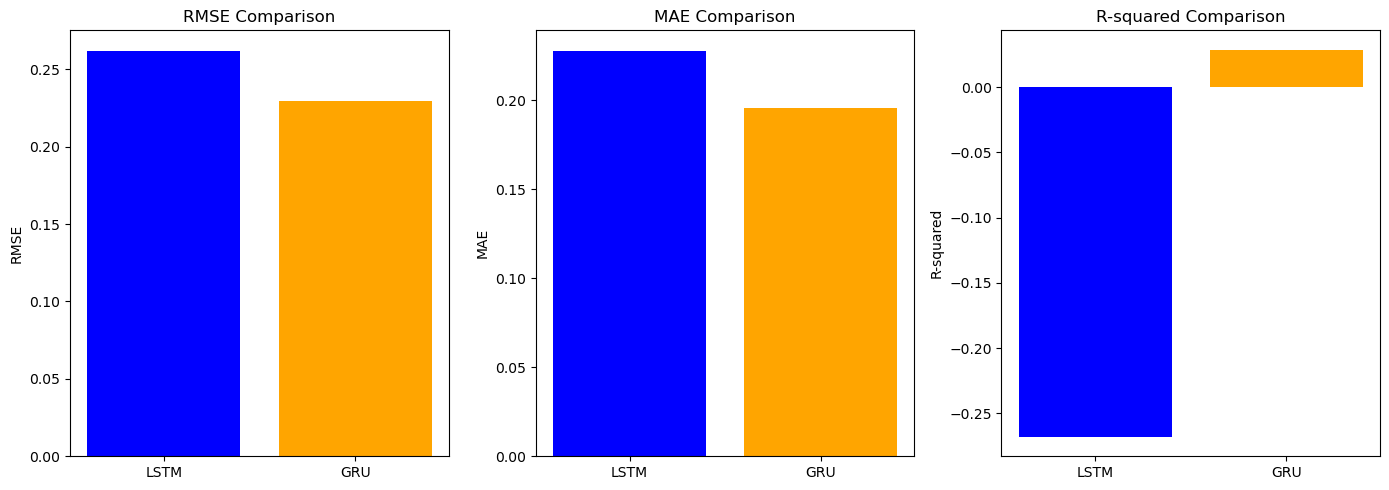

In [ ]:
# Comparison of model performance with sentiment integration
models = ['LSTM', 'GRU']
rmse_scores = [rmse_lstm, rmse_gru]
mae_scores = [mae_lstm, mae_gru]
r2_scores = [r2_lstm, r2_gru]

x = np.arange(len(models))

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.bar(x, rmse_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
plt.bar(x, mae_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('MAE Comparison')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.bar(x, r2_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('R-squared Comparison')
plt.ylabel('R-squared')

plt.tight_layout()
plt.show()


In [ ]:
# Function to process data for a specific stock
def process_stock_data(stock_data):
    stock_data = stock_data.rolling(window=50).mean()
    stock_data = stock_data.bfill()
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))
    return stock_data, data_scaled, scaler

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Function to split data into training and testing sets
def split_data(data, split_ratio=0.8):
    train_size = int(len(data) * split_ratio)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data

# Function to build and train LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=2, batch_size=1, time_step=10):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

# Function to build and train GRU model
def build_and_train_gru(X_train, y_train, X_test, y_test, epochs=2, batch_size=1, time_step=10):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

# Function to evaluate model
def evaluate_model(model, X_test, y_test, scaler):
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = np.corrcoef(y_test, test_predict)[0, 1] ** 2
    return rmse, mae, r2, y_test, test_predict

# Function to plot projected stock prices
def plot_projected_prices(dates, y_test, test_predict, title):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, y_test, label='Actual Stock Price', color='blue')
    plt.plot(dates, test_predict, label='Predicted Stock Price', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [ ]:
# Model Training and Evaluation for Each Stock
time_step = 10  # Further reduced time step to ensure there is enough data
split_ratios = [0.8]  # List of split ratios
hyperparams = [{'epochs': 2, 'batch_size': 1}, {'epochs': 2, 'batch_size': 32}]
stocks = ['AAPL', 'GOOGL', 'MSFT']

for stock in stocks:
    stock_data = data[stock]  # Get specific stock data as a Series
    stock_data, data_scaled, scaler = process_stock_data(stock_data)
    print(f"Data length for {stock} after scaling: {len(data_scaled)}")  # Debugging line
    if len(data_scaled) <= time_step:
        print(f"Not enough data for stock {stock} with time_step {time_step}")
        continue
    
    for split_ratio in split_ratios:
        train_data, test_data = split_data(data_scaled, split_ratio)
        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)
        
        # Check if there is enough data to reshape
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data for stock {stock} with time_step {time_step}")
            continue

        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Train and evaluate LSTM models
        for params in hyperparams:
            model_lstm, history_lstm = build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'], time_step=time_step)
            rmse_lstm, mae_lstm, r2_lstm, y_test_lstm, test_predict_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
            start_date = pd.to_datetime('2024-01-01')
            dates = pd.date_range(start=start_date, periods=len(y_test_lstm), freq='D')
            plot_projected_prices(dates, y_test_lstm, test_predict_lstm, f'Projected Stock Prices using LSTM for {stock} with split ratio {split_ratio}')

        # Train and evaluate GRU models
        for params in hyperparams:
            model_gru, history_gru = build_and_train_gru(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'], time_step=time_step)
            rmse_gru, mae_gru, r2_gru, y_test_gru, test_predict_gru = evaluate_model(model_gru, X_test, y_test, scaler)
            start_date = pd.to_datetime('2024-01-01')
            dates = pd.date_range(start=start_date, periods=len(y_test_gru), freq='D')
            plot_projected_prices(dates, y_test_gru, test_predict_gru, f'Projected Stock Prices using GRU for {stock} with split ratio {split_ratio}')








Data length for AAPL after scaling: 3526
Epoch 1/2
2032/2809 [====================>.........] - ETA: 41s - loss: 3.2848e-04

KeyboardInterrupt: 